# Proyecto Redes Neuronales: RNN Simple (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo RNN sin memoria usando PyTorch  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Descripcion del Modelo

La **RNN Simple (Elman RNN)** es una red neuronal recurrente basica sin mecanismos de memoria a largo plazo. Procesa secuencias de forma iterativa pero puede sufrir de problemas de gradiente desvaneciente en secuencias largas.

**Tecnicas aplicadas:**
- Gradient Clipping para prevenir explosion de gradientes
- Arquitectura bidireccional para capturar contexto en ambas direcciones
- Average Pooling sobre toda la secuencia

## 0. Configuración de Parámetros Globales

In [ ]:
# Configuracion del experimento
EXPERIMENT_NAME = "SimpleRNN_PyTorch"
MODEL_TYPE = "SimpleRNN_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_2"

# Directorios
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"
USE_TITLE_AND_BODY = True

# Tokenizacion
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 120

# Arquitectura del modelo
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT_RATE = 0.3

# Entrenamiento
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PATIENCE = 5
WEIGHT_DECAY = 5e-5
CLIP_GRAD_NORM = 1.5
USE_CLASS_WEIGHTS = True

print(f"=== Configuracion: {EXPERIMENT_NAME} ===")
print(f"Arquitectura: Embedding {EMBEDDING_DIM}d, Hidden {HIDDEN_SIZE}, Bidireccional: {BIDIRECTIONAL}")
print(f"Entrenamiento: LR={LEARNING_RATE}, Batch={BATCH_SIZE}, Patience={PATIENCE}")
print("="*60)

=== Configuracion: SimpleRNN_PyTorch ===
Arquitectura: Embedding 128d, Hidden 128, Bidireccional: True
Entrenamiento: LR=0.001, Batch=64, Patience=5


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import SimpleRNNClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070


## 2. Carga y Preprocesamiento de Datos

In [3]:
print("=== Cargando datos ===")

# Inicializar DataLoader
data_loader = DataLoaderTorch(data_dir=DATA_DIR)

# Cargar datasets
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nTamaños de conjuntos:")
print(f"  Entrenamiento: {len(train_df):,}")
print(f"  Validación: {len(val_df):,}")
print(f"  Prueba: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE:
    if LANGUAGE_COLUMN in train_df.columns:
        print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
        train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        print(f"Tamaños después de filtrar:")
        print(f"  Entrenamiento: {len(train_df):,}")
        print(f"  Validación: {len(val_df):,}")
        print(f"  Prueba: {len(test_df):,}")

# Verificar distribución de clases
if TARGET_COLUMN in train_df.columns:
    print(f"\nDistribución de clases (entrenamiento):")
    for i in range(1, 6):
        count = len(train_df[train_df[TARGET_COLUMN] == i])
        print(f"  Clase {i} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

=== Cargando datos ===
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamaños de conjuntos:
  Entrenamiento: 1,200,000
  Validación: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamaños de conjuntos:
  Entrenamiento: 1,200,000
  Validación: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Tamaños después de filtrar:
  Entrenamiento: 200,000
  Validación: 5,000
  Prueba: 5,000

Distribución de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20.0%)
  Clase 3 estrellas: 40,000 (20.0%)
  Clase 4 estrellas: 40,000 (20.0%)
  Clase 5 estrellas: 40,000 (20.0%)
Tamaños después de filtrar:
  Entrenamiento: 200,000
  Validación: 5,000
  Prueba: 5,000

Distribución de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20

## 3. Preprocesamiento y Creación de DataLoaders

Esta celda realiza:
- Tokenización de textos
- Construcción de vocabulario
- Conversión a secuencias numéricas
- Padding de secuencias
- Creación de DataLoaders de PyTorch

In [4]:
print("=== Preprocesando datos para embeddings ===")

# Preprocesar datos usando el método de embedding
preprocessing_result = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer resultados
train_loader = preprocessing_result['train_loader']
val_loader = preprocessing_result['val_loader']
test_loader = preprocessing_result['test_loader']
num_classes = preprocessing_result['num_classes']
vocab_size = preprocessing_result['vocab_size']
pad_idx = 0  # Keras siempre usa 0 como padding index

print(f"\nVocabulario construido:")
print(f"  Tamaño del vocabulario: {vocab_size:,}")
print(f"  Índice de padding: {pad_idx}")
print(f"  Número de clases: {num_classes}")
print(f"  Max length: {MAX_LENGTH}")

print(f"\nDataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Ejemplo de un batch
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Forma de secuencias: {sample_batch[0].shape}")
print(f"  Forma de labels: {sample_batch[1].shape}")

=== Preprocesando datos para embeddings ===
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 20000
Número de clases: 5
Longitud de secuencia: 120
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamaño del vocabulario: 20,000
  Índice de padding: 0
  Número de clases: 5
  Max length: 120

DataLoaders creados:
  Train batches: 3125
  Val batches: 79
  Test batches: 79

Ejemplo de batch:
  Forma de secuencias: torch.Size([64, 120])
  Forma de labels: torch.Size([64])
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 20000
Número de clases: 5
Longitud de secuencia: 120
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamaño del vocabulario: 20,000

## 4. Construcción del Modelo SimpleRNN

In [5]:
print("=== Construyendo modelo SimpleRNN ===")

# Crear modelo
model = SimpleRNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_classes=num_classes,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
    padding_idx=pad_idx,
    bidirectional=BIDIRECTIONAL
)

print(f"\nArquitectura del modelo:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

=== Construyendo modelo SimpleRNN ===

Arquitectura del modelo:
SimpleRNNClassifier(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

Parámetros totales: 2,726,149
Parámetros entrenables: 2,726,149


## 5. Configuración del Entrenamiento

In [6]:
print("=== Configurando entrenamiento ===")

# Calcular class weights para manejar desbalanceo
y_train_np = preprocessing_result['y_train'].numpy()
class_counts = np.bincount(y_train_np)
total_samples = len(y_train_np)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights) if USE_CLASS_WEIGHTS else None

print(f"Distribucion de clases:")
for i, count in enumerate(class_counts):
    weight_str = f"weight: {class_weights[i]:.4f}" if USE_CLASS_WEIGHTS else "weight: 1.0"
    print(f"  Clase {i+1}: {count:,} muestras, {weight_str}")

# Funcion de perdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None
)

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"\nOptimizador: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

=== Configurando entrenamiento ===
Distribucion de clases:
  Clase 1: 40,000 muestras, weight: 1.0000
  Clase 2: 40,000 muestras, weight: 1.0000
  Clase 3: 40,000 muestras, weight: 1.0000
  Clase 4: 40,000 muestras, weight: 1.0000
  Clase 5: 40,000 muestras, weight: 1.0000

Optimizador: Adam (lr=0.001, weight_decay=5e-05)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)

Optimizador: Adam (lr=0.001, weight_decay=5e-05)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


## 6. Entrenamiento del Modelo

In [7]:
print("=== Iniciando entrenamiento ===")

# Inicializar trainer
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

# Entrenar modelo con gradient clipping
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=MODEL_TYPE,
    scheduler=scheduler,
    clip_grad_norm=CLIP_GRAD_NORM,  # Gradient clipping para RNN
    verbose=True
)

print(f"\n=== Entrenamiento completado ===")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo total: {training_results['training_time']:.2f}s")
print(f"Mejor Val Loss: {training_results['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {training_results['best_val_accuracy']:.4f}")

=== Iniciando entrenamiento ===
Usando dispositivo: cuda

Entrenando SimpleRNN_Torch...
Parámetros totales: 2,726,149
Parámetros entrenables: 2,726,149
Gradient clipping activado: max_norm=1.5


Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 722.67it/s, loss=0.4671, acc=56.24%]



Epoch 1/50:
  Train Loss: 1.0421, Train Acc: 0.5492
  Val Loss: 1.0058, Val Acc: 0.5624
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 1.0058)


Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 576.05it/s, loss=0.4361, acc=56.82%]



Epoch 2/50:
  Train Loss: 0.9644, Train Acc: 0.5850
  Val Loss: 0.9792, Val Acc: 0.5682
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9792)


Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 605.09it/s, loss=0.5219, acc=57.70%]



Epoch 3/50:
  Train Loss: 0.9448, Train Acc: 0.5951
  Val Loss: 0.9614, Val Acc: 0.5770
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9614)


Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 702.74it/s, loss=0.4338, acc=57.66%]



Epoch 4/50:
  Train Loss: 0.9329, Train Acc: 0.5973
  Val Loss: 0.9607, Val Acc: 0.5766
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9607)


Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 718.11it/s, loss=0.2588, acc=57.72%]



Epoch 5/50:
  Train Loss: 0.9182, Train Acc: 0.6057
  Val Loss: 0.9539, Val Acc: 0.5772
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9539)


Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 665.97it/s, loss=0.3523, acc=58.62%]



Epoch 6/50:
  Train Loss: 0.9104, Train Acc: 0.6069
  Val Loss: 0.9697, Val Acc: 0.5862
  Learning Rate: 0.001000
  Épocas sin mejora: 1/5


Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 728.34it/s, loss=0.3439, acc=58.28%]



Epoch 7/50:
  Train Loss: 0.9042, Train Acc: 0.6102
  Val Loss: 0.9458, Val Acc: 0.5828
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9458)


Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 526.37it/s, loss=0.3969, acc=58.92%]



Epoch 8/50:
  Train Loss: 0.8916, Train Acc: 0.6169
  Val Loss: 0.9430, Val Acc: 0.5892
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9430)


Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 731.08it/s, loss=0.5034, acc=56.84%]



Epoch 9/50:
  Train Loss: 0.8852, Train Acc: 0.6195
  Val Loss: 0.9669, Val Acc: 0.5684
  Learning Rate: 0.001000
  Épocas sin mejora: 1/5


Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 674.16it/s, loss=0.2953, acc=59.36%]



Epoch 10/50:
  Train Loss: 0.8820, Train Acc: 0.6219
  Val Loss: 0.9539, Val Acc: 0.5936
  Learning Rate: 0.001000
  Épocas sin mejora: 2/5


Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 722.96it/s, loss=0.4358, acc=58.30%]



Epoch 11/50:
  Train Loss: 0.8862, Train Acc: 0.6179
  Val Loss: 0.9562, Val Acc: 0.5830
  Learning Rate: 0.000500
  Épocas sin mejora: 3/5


Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 736.30it/s, loss=0.2932, acc=59.08%]



Epoch 12/50:
  Train Loss: 0.8447, Train Acc: 0.6388
  Val Loss: 0.9388, Val Acc: 0.5908
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9388)


Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 695.69it/s, loss=0.3375, acc=58.46%]



Epoch 13/50:
  Train Loss: 0.8306, Train Acc: 0.6449
  Val Loss: 0.9420, Val Acc: 0.5846
  Learning Rate: 0.000500
  Épocas sin mejora: 1/5


Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 700.56it/s, loss=0.5656, acc=58.68%]



Epoch 14/50:
  Train Loss: 0.8263, Train Acc: 0.6477
  Val Loss: 0.9562, Val Acc: 0.5868
  Learning Rate: 0.000500
  Épocas sin mejora: 2/5


Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 665.41it/s, loss=0.2556, acc=59.10%]



Epoch 15/50:
  Train Loss: 0.8205, Train Acc: 0.6507
  Val Loss: 0.9427, Val Acc: 0.5910
  Learning Rate: 0.000250
  Épocas sin mejora: 3/5


Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 686.25it/s, loss=0.3317, acc=59.48%]



Epoch 16/50:
  Train Loss: 0.7863, Train Acc: 0.6669
  Val Loss: 0.9542, Val Acc: 0.5948
  Learning Rate: 0.000250
  Épocas sin mejora: 4/5


Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 698.80it/s, loss=0.3581, acc=58.62%]




Epoch 17/50:
  Train Loss: 0.7773, Train Acc: 0.6718
  Val Loss: 0.9594, Val Acc: 0.5862
  Learning Rate: 0.000250
  Épocas sin mejora: 5/5

Early stopping en época 17

Mejor modelo restaurado
Modelo guardado en: models/project_part_2/SimpleRNN_Torch.pth

=== Entrenamiento completado ===
Épocas entrenadas: 17
Tiempo total: 179.43s
Mejor Val Loss: 0.9388
Mejor Val Accuracy: 0.5908


## 7. Evaluación en Conjunto de Prueba

In [8]:
print("=== Evaluando en conjunto de prueba ===")

# Evaluar modelo
test_results = trainer.evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion
)

print(f"\n=== Resultados en Test ===")
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1} estrellas" for i in range(num_classes)],
    digits=4
))

=== Evaluando en conjunto de prueba ===

Evaluando modelo en conjunto de prueba...


Evaluando: 100%|██████████| 79/79 [00:00<00:00, 837.34it/s]


Test Loss: 0.9762
Test Accuracy: 0.5974

=== Resultados en Test ===
Test Loss: 0.9762
Test Accuracy: 0.5974

Reporte de clasificación:
              precision    recall  f1-score   support

 1 estrellas     0.6866    0.6880    0.6873      1000
 2 estrellas     0.4837    0.6100    0.5396      1000
 3 estrellas     0.5123    0.4180    0.4604      1000
 4 estrellas     0.5883    0.5030    0.5423      1000
 5 estrellas     0.7205    0.7680    0.7435      1000

    accuracy                         0.5974      5000
   macro avg     0.5983    0.5974    0.5946      5000
weighted avg     0.5983    0.5974    0.5946      5000



## 8. Visualización de Resultados

=== Generando visualizaciones ===
Gráfico de historial de entrenamiento guardado en: output/project_part_2/SimpleRNN_Torch_history.png
Gráfico de historial de entrenamiento guardado en: output/project_part_2/SimpleRNN_Torch_history.png


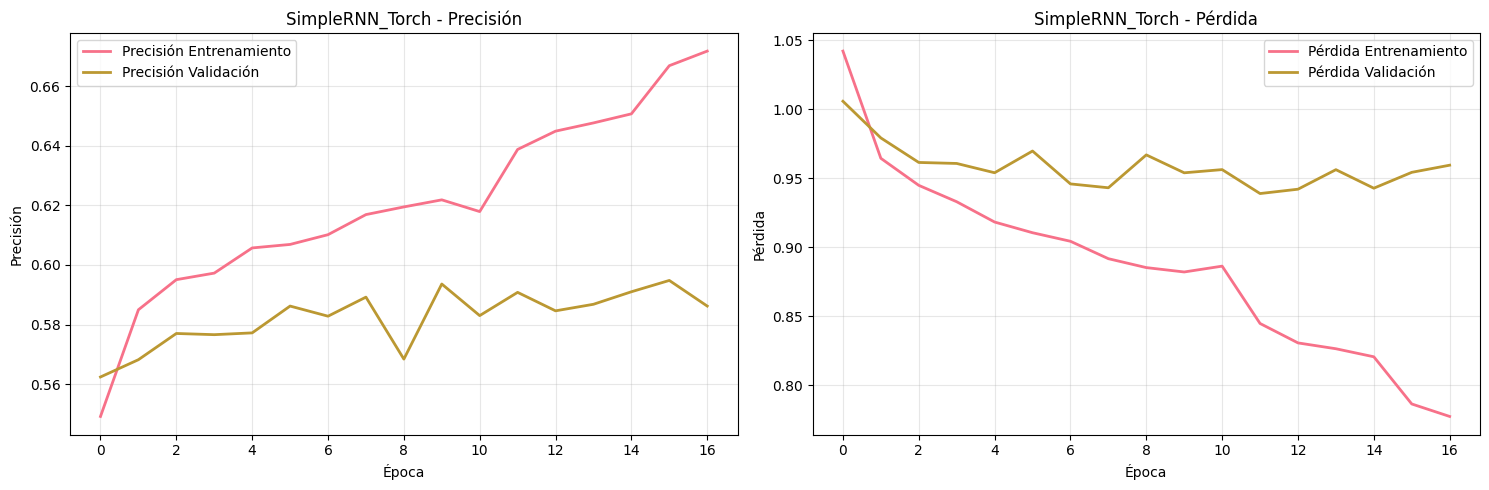

Matriz de confusión guardada en: output/project_part_2/SimpleRNN_Torch_confusion_matrix.png


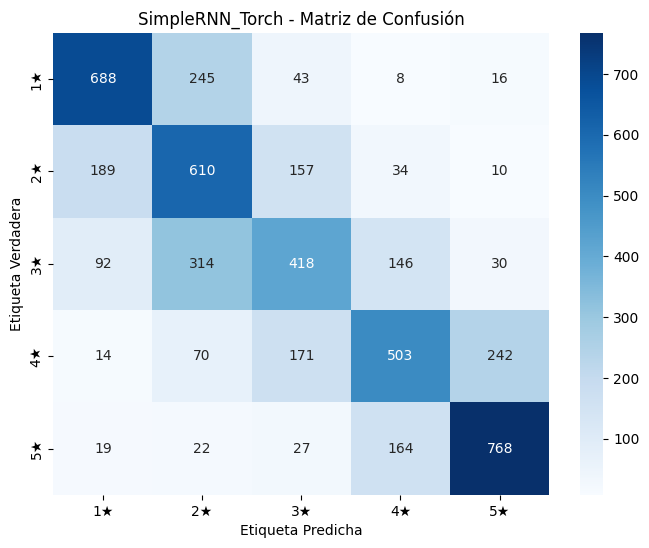

Visualizaciones guardadas en: output/project_part_2


In [9]:
print("=== Generando visualizaciones ===")

# Historia de entrenamiento
history = training_results['history']

# Graficar historia de entrenamiento (pérdida y accuracy)
Visualizer.plot_training_history(
    history=history,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_history.png'),
    framework='pytorch'
)

# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=test_results['labels'],
    y_pred=test_results['predictions'],
    class_names=[f"{i+1}★" for i in range(num_classes)],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_confusion_matrix.png')
)

print("Visualizaciones guardadas en:", OUTPUT_DIR)

## 9. Guardado de Resultados del Experimento

In [10]:
print("=== Guardando resultados del experimento ===")

# Reporte de clasificacion
from sklearn.metrics import classification_report as sklearn_classification_report
classification_rep = sklearn_classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1}★" for i in range(num_classes)],
    output_dict=True
)

# Guardar componentes para demo
save_model_components_torch(
    model_name=MODEL_TYPE,
    model=model,
    tokenizer=data_loader.tokenizer,
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'bidirectional': BIDIRECTIONAL,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'clip_grad_norm': CLIP_GRAD_NORM,
        'patience': PATIENCE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'use_title_and_body': USE_TITLE_AND_BODY
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_results['test_accuracy'],
        'test_loss': test_results['test_loss'],
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar experimento
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Modelo guardado en: {MODEL_DIR}/{MODEL_TYPE}.pth")

=== Guardando resultados del experimento ===
Modelo guardado: models/project_part_2/SimpleRNN_Torch.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 128, 'hidden_size': 128, 'num_classes': 5, 'num_layers': 2, 'bidirectional': True, 'max_length': 120}
Tokenizer guardado: models/project_part_2/SimpleRNN_Torch_tokenizer.pkl
Label encoder guardado: models/project_part_2/SimpleRNN_Torch_label_encoder.pkl
Componentes guardados en models/project_part_2/
Experiment 1 results saved to output/project_part_2/experiment_history.json

Experimento #1 guardado
Modelo guardado en: models/project_part_2/SimpleRNN_Torch.pth
